In [3]:
import glob, os 
import datetime
from datetime import date
import pandas_market_calendars as mcal
import csv
import os

import numpy as np
import pandas as pd
import random
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt

from xgboost import XGBClassifier
from xgboost import XGBRegressor

pd.set_option('display.max_rows', 5000)
pd.set_option('display.max_columns', 1000)
pd.set_option('display.width', 5000)

data_path=r'X:\QTS Capital Dropbox\Backtests\UltraMOM2\Ian\bid_ask_research\binary_data'
backtest_path=r'X:\QTS Capital Dropbox\Backtests\UltraMOM2\Ian\bid_ask_research\Logs'

df_list = []
for file in os.listdir(data_path):
    df_list.append(os.path.join(data_path,file))  # all csv file in this
    
    
df_list2 = []
for file in os.listdir(backtest_path):
    df_list2.append(os.path.join(backtest_path,file))  # all csv file in this

base_tr_path = [s for s in df_list2 if ('_SPY_ES_VIX2_PL.csv' in s) and ('TailReaperGeneral'in s)][-1]
opposite_tr_path = [s for s in df_list2 if ('_SPY_ES_VIX2_Opposite_PL.csv' in s) and ('TailReaperGeneral'in s)][-1]
execs_file_path = [s for s in df_list2 if ('_SPY_ES_VIX2_Execs.csv' in s) and ('TailReaperGeneral'in s)][-1]

# base_tr_path = [s for s in df_list2 if ('_SPY_ES_VIX2_PL.csv' in s) and ('UltraMOM2'in s)][-1]
# opposite_tr_path = [s for s in df_list2 if ('_SPY_ES_VIX2_Opposite_PL.csv' in s) and ('UltraMOM2'in s)][-1]
# execs_file_path = [s for s in df_list2 if ('_SPY_ES_VIX2_Execs.csv' in s) and ('UltraMOM2'in s)][-1]

features_path1 = [s for s in df_list if 'createFeatures_new.csv' in s][-1]

# Trading days and holidays for NYSE 
nyse = mcal.get_calendar('NYSE')
trading_days_nyse = nyse.valid_days(start_date='2013-02-25', end_date = date.today())
holidays_nyse = nyse.holidays().holidays



# assert date.today() == trading_days_nyse[-1].date(), 'Today\'s date is a holiday, no binary prediction'
# print('Today\'s date is a trading day')


def data_processing(features_data, pnl_data, holidays):

    df = pd.read_csv(pnl_data, names=['Time', 'return_to_exit'])
    df.set_index('Time', inplace=True)
    df.index = pd.to_datetime(df.index)
    df = df.resample('d').last()
    df = df - df.shift()

    df.dropna(inplace=True)

    df = df[df['return_to_exit'] != 0.0]

    df = df[df['return_to_exit'] != -2.32]

    feature_150 = pd.read_csv(features_data, index_col=0)


    feature_150.index = pd.to_datetime(feature_150.index)

    feature_150.loc[feature_150.index[-1] + pd.tseries.offsets.CustomBusinessDay(n = 1, holidays=holidays)] = [i for i in range(len(list(feature_150.columns)))]

    
    feature_150 = feature_150.shift()

    
    feature_columns = list(feature_150.columns)

    df = feature_150.merge(df, left_index=True, right_index=True, how='left')

    df = df[df['return_to_exit'] != 0.00]

    features_prediction = df.iloc[[-1],:]
    
    df = df.iloc[:-1,:]
    

    df.dropna(inplace=True, axis=0)
    display(df.tail())
    df = df.append(features_prediction)

    df['pnl_lag_1'] = df['return_to_exit'].shift()

    
    df['pnl_roll_mean'] = df['pnl_lag_1'].rolling(5).mean()
    df['pnl_roll_mean2'] = df['pnl_lag_1'].rolling(15).mean()
    
    return df

#df = data_processing(features_path, base_tr_path, holidays=holidays_nyse) 

In [4]:
print(features_path1)

X:\QTS Capital Dropbox\Backtests\UltraMOM2\Ian\bid_ask_research\binary_data\createFeatures_new.csv


In [5]:
print(base_tr_path, opposite_tr_path)


X:\QTS Capital Dropbox\Backtests\UltraMOM2\Ian\bid_ask_research\Logs\TailReaperGeneral{2022-10-14-[17-01-35]}_SPY_ES_VIX2_PL.csv X:\QTS Capital Dropbox\Backtests\UltraMOM2\Ian\bid_ask_research\Logs\TailReaperGeneral{2022-10-12-[12-36-23]}_SPY_ES_VIX2_Opposite_PL.csv


In [6]:
df1 = data_processing(features_path1, base_tr_path, holidays=holidays_nyse)

,VIX_Close,VIX_Close_D1,VIX_OpenGap,VIX_MA5,VIX_MA20,VIX_MA1_20,VIX_MA1_5,VIX_MA5_20,VIX_RSI5,VIX_RSI20,VXN_Close,VXN_MA5,VXN_MA20,VXN_MA1_20,VXN_MA1_5,VXN_MA5_20,VXN_RSI5,VXN_RSI20,VXD_Close,VXD_MA5,VXD_MA20,VXD_MA1_20,VXD_MA1_5,VXD_MA5_20,VXD_RSI5,VXD_RSI20,RVX_Close,RVX_MA5,RVX_MA20,RVX_MA1_20,RVX_MA1_5,RVX_MA5_20,RVX_RSI5,RVX_RSI20,SKEW,SKEW_MA5,SKEW_MA20,SKEW_MA1_20,SKEW_MA1_5,SKEW_MA5_20,VVIX,VVIX_MA5,VVIX_MA20,VVIX_MA1_20,VVIX_MA1_5,VVIX_MA5_20,SPX_logD1,SPX_logD2,SPX_logD5,SPX_logOpenGap,SPX_logDayRet,SPX_logMA1_250,SPX_logMA1_20,SPX_logMA1_5,SPX_logMA5_250,SPX_logMA5_20,SPX_logMA20_250,SPX_RSI5,SPX_RSI20,SPX_logDayRange_1,SPX_logDayRange_5,SPX_logDayRange_20,SPX_logDayRange_1_20,SPX_realVolatility_20,SPX_realVolatility_60,SPX_realVolatility_20_60,SPX_VIX_realVol_20,SPY_volumeRatio_20,SPY_volumeRatio_250,RUT_logD1,RUT_logD2,RUT_logD5,RUT_logOpenGap,RUT_logDayRet,RUT_logMA1_250,RUT_logMA1_20,RUT_logMA1_5,RUT_logMA5_250,RUT_logMA5_20,RUT_logMA20_250,RUT_RSI5,RUT_RSI20,RUT_logDayRange_1,RUT_logDayRange_5,RUT_logDayRange_20,RUT_logDayRange_1_20,RUT_realVolatility_20,RUT_realVolatility_60,RUT_realVolatility_20_60,RUT_VIX_realVol_20,IWM_volumeRatio_20,IWM_volumeRatio_250,GLD_logD1,GLD_logD2,GLD_logD5,GLD_logOpenGap,GLD_logDayRet,GLD_logMA5_20,GLD_logMA5_250,GLD_logMA1_250,GLD_RSI5,GLD_RSI20,GLD_dayRangeRatio_250,GLD_realVolatility_20,GLD_realVolatility_60,GLD_realVolatility_20_60,GLD_volumeRatio_20,GLD_volumeRatio_250,HYG_logD1,HYG_logD2,HYG_logD5,HYG_logMA5_20,HYG_logMA5_250,HYG_logMA1_250,HYG_RSI5,HYG_RSI20,HYG_dayRangeRatio_250,HYG_realVolatility_20,HYG_realVolatility_60,HYG_realVolatility_20_60,HYG_volumeRatio_20,HYG_volumeRatio_250,TR10_logD1,TR10_logD2,TR10_logD5,TR10_logMA5_20,TR10_logMA5_250,TR10_logMA1_250,TR10_RSI5,TR10_RSI20,TR10_realVolatility_20,TR10_realVolatility_60,TR10_realVolatility_20_60,TR10_TR5,TR10_TR1,TR10_TR3M,SPX_HL_1_realVol_20,SPX_HL_5_realVol_20,SPX_HL_20_realVol_20,return_to_exit
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2022-10-03,31.62,-0.22,-0.23,31.700,27.4985,4.1215,-0.080,4.2015,64.481494,61.649414,36.61,36.622,33.4330,3.1770,-0.012,3.1890,64.150956,60.556651,26.41,26.962,23.7220,2.6880,-0.552,3.2400,57.577666,59.043147,36.77,37.010,32.2565,4.5135,-0.240,4.7535,67.178804,63.073731,123.59,121.182,119.5875,4.0025,2.408,1.5945,106.19,108.636,95.2145,10.9755,-2.446,13.4215,-0.015181,-0.036534,-0.029570,-0.001922,-0.013259,-0.177824,-0.069765,-0.017657,-0.160167,-0.052109,-0.108059,21.656966,32.113297,0.024068,0.023215,0.019041,0.005027,0.244194,0.217589,0.026605,-356.025912,1.601018,1.677324,-0.006114,-0.029896,-0.008893,-0.001219,-0.004896,-0.181424,-0.064173,-0.005951,-0.175473,-0.058222,-0.117251,31.188598,36.076226,0.025790,0.028630,0.022495,0.003295,0.017932,0.015998,0.001934,31.602068,1.344082,1.273958,0.000065,-0.000129,0.010791,0.001809,-0.001744,-0.019185,-0.102125,-0.093607,52.699447,40.541850,0.975370,0.009401,0.008219,0.001183,1.031394,0.778259,-0.004612,-0.014048,-0.010312,-0.028215,-0.097342,-0.100056,31.551561,35.731299,1.631053,0.009338,0.008239,0.001099,1.128315,1.133984,0.018446,0.029141,0.037238,0.081523,0.460297,0.459775,63.323957,67.077413,0.025589,0.024903,0.000685,-0.23,-0.22,0.50,1.564620,1.509133,1.237827,632.86
2022-10-04,30.10,-1.52,1.38,31.268,27.7300,2.3700,-1.168,3.5380,49.390433,57.553325,35.56,36.348,33.5950,1.9650,-0.788,2.7530,51.039214,57.409740,25.97,26.720,23.9010,2.0690,-0.750,2.8190,52.178748,57.732974,35.81,36.652,32.5480,3.2620,-0.842,4.1040,54.981904,60.187658,121.38,121.456,119.6660,1.7140,-0.076,1.7900,103.03,107.424,95.9065,7.1235,-4.394,11.5175,0.025555,0.010373,0.006379,0.006715,0.018839,-0.151515,-0.041008,0.006617,-0.158132,-0.047626,-0.110506,45.564894,38.604704,0.025584,0.024478,0.018904,0.006680,0.266304,0.223396,0.042908,-392.644298,0.939715,0.978263,0.026175,0.020061,0.031500,0.013461,0.012715,-0.154128,-0.035152,0.013916,-0.168044,-0.04906

In [7]:
# ### Df for backtesting
df_tr = pd.read_csv(base_tr_path, names=['Time', 'base_tr_pnl'])

df_tr.set_index('Time', inplace=True)

df_inv = pd.read_csv(opposite_tr_path, names=['Time', 'opposite_tr_pnl'])
df_inv.set_index('Time', inplace=True)

df_backtest = df_tr.copy()
df_backtest.index = pd.to_datetime(df_backtest.index)
df_backtest = df_backtest.resample('d').last()

entry_exit = pd.read_csv(execs_file_path, names=[i for i in range(15)])

display(df_tr.head(), df_backtest.head(), entry_exit.head())
entry_exit = entry_exit[[1,2,3,6]]
entry_exit.columns = ['time', 'transaction_type', 'buy_sold_price', 'nominal pnl']
entry_exit = entry_exit[entry_exit['transaction_type'] == 'Bought']
entry_exit['time'] = pd.to_datetime(entry_exit['time'].str.slice(stop=8))
entry_exit.set_index('time', inplace=True)

df_backtest = df_backtest.merge(entry_exit, left_index=True, right_index=True)

df_backtest['base_tr_pnl'] = df_backtest['base_tr_pnl']- df_backtest['base_tr_pnl'].shift()
#df_backtest['opposite_tr_pnl'] = df_backtest['opposite_tr_pnl']- df_backtest['opposite_tr_pnl'].shift()
df_backtest.dropna(inplace=True)


# Real Returns
df_backtest['base_tr_pnl'] = df_backtest['base_tr_pnl']/(df_backtest['buy_sold_price'] * 50)
#df_backtest['opposite_tr_pnl'] = df_backtest['opposite_tr_pnl']/(df_backtest['buy_sold_price'] * 50)


# Nominal Returns 
# df_backtest['base_tr_pnl'] = df_backtest['base_tr_pnl']/(100000/3)
# df_backtest['opposite_tr_pnl'] = df_backtest['opposite_tr_pnl']/(100000/3)

df_backtest = df_backtest[df_backtest['base_tr_pnl'] != 0.0]

df_backtest = df_backtest[df_backtest['base_tr_pnl'] != -2.32]

df_backtest.drop(columns=['buy_sold_price', 'nominal pnl', 'transaction_type'], inplace=True)
df_backtest.head()

,base_tr_pnl
Time,
20100104 13:35:00.000,-14.82
20100104 13:40:00.000,-27.32
20100104 13:45:00.000,-14.82
20100104 13:50:00.000,-39.82
20100104 13:55:00.000,-77.32


,base_tr_pnl
Time,
2010-01-04,-42.14
2010-01-05,-42.14
2010-01-06,-42.14
2010-01-07,-42.14
2010-01-08,-42.14


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,ES_1003_FUT,20100104 13:30,Bought,1129.50,1,2.32,0.0,1,Historical,1,EST,TailReaperGeneral,SPY_ES_VIX2,NaN,HISTORY
1,ES_1003_FUT,20100104 16:00,Sold,1128.75,1,2.32,-37.5,2,Historical,2,EST,TailReaperGeneral,SPY_ES_VIX2,NaN,HISTORY
2,ES_1003_FUT,20100112 15:32,Sold,1130.75,1,2.32,0.0,3,Historical,3,EST,TailReaperGeneral,SPY_ES_VIX2,NaN,HISTORY
3,ES_1003_FUT,20100112 16:00,Bought,1132.00,1,2.32,-62.5,4,Historical,4,EST,TailReaperGeneral,SPY_ES_VIX2,NaN,HISTORY
4,ES_1003_FUT,20100113 15:32,Bought,1143.25,1,2.32,0.0,5,Historical,5,EST,TailReaperGeneral,SPY_ES_VIX2,NaN,HISTORY


,base_tr_pnl
2010-01-12,-0.001186
2010-01-13,-0.000956
2010-01-15,-0.002290
2010-01-19,-0.000081
2010-01-20,-0.006252


In [8]:
df_backtest.to_csv('basetr_returns.csv')

Random State: 1656
Random State: 5989


C:\Users\Ian\AppData\Local\Temp\4/ipykernel_18280/3871241158.py:265: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reg_bin1['Predicted Value Binary'][reg_bin1['Predicted Value Binary'] <= 0] = -1
C:\Users\Ian\AppData\Local\Temp\4/ipykernel_18280/3871241158.py:266: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reg_bin1['Predicted Value Binary'][reg_bin1['Predicted Value Binary'] > 0] = 1


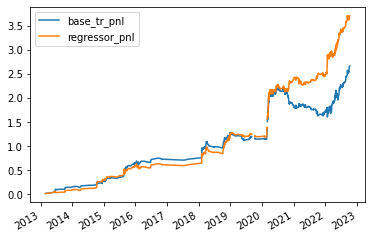

In [9]:
# ### Df for backtesting
df_tr = pd.read_csv(base_tr_path, names=['Time', 'base_tr_pnl'])
df_tr.set_index('Time', inplace=True)

df_inv = pd.read_csv(opposite_tr_path, names=['Time', 'opposite_tr_pnl'])
df_inv.set_index('Time', inplace=True)

df_backtest = df_tr.merge(df_inv, left_index=True, right_index=True)
df_backtest.index = pd.to_datetime(df_backtest.index)
df_backtest = df_backtest.resample('d').last()

entry_exit = pd.read_csv(execs_file_path, names=[i for i in range(15)])

entry_exit = entry_exit[[1,2,3,6]]
entry_exit.columns = ['time', 'transaction_type', 'buy_sold_price', 'nominal pnl']
entry_exit = entry_exit[entry_exit['transaction_type'] == 'Bought']
entry_exit['time'] = pd.to_datetime(entry_exit['time'].str.slice(stop=8))
entry_exit.set_index('time', inplace=True)

df_backtest = df_backtest.merge(entry_exit, left_index=True, right_index=True)

df_backtest['base_tr_pnl'] = df_backtest['base_tr_pnl']- df_backtest['base_tr_pnl'].shift()
df_backtest['opposite_tr_pnl'] = df_backtest['opposite_tr_pnl']- df_backtest['opposite_tr_pnl'].shift()
df_backtest.dropna(inplace=True)


# Real Returns
# df_backtest['base_tr_pnl'] = df_backtest['base_tr_pnl']/(df_backtest['buy_sold_price'] * 50)
# df_backtest['opposite_tr_pnl'] = df_backtest['opposite_tr_pnl']/(df_backtest['buy_sold_price'] * 50)


# Nominal Returns 
df_backtest['base_tr_pnl'] = df_backtest['base_tr_pnl']/(100000/3)
df_backtest['opposite_tr_pnl'] = df_backtest['opposite_tr_pnl']/(100000/3)

df_backtest = df_backtest[df_backtest['base_tr_pnl'] != 0.0]

df_backtest = df_backtest[df_backtest['base_tr_pnl'] != -2.32]

df_backtest.drop(columns=['buy_sold_price', 'nominal pnl'], inplace=True)

def apply_sw_method(df, pred_feature, window_range, test_size, classifier=False, random_state=0):
    
    """
    It runs a prediction model using sliding windown method.

    args:
    data, (PandasDataFrame): Input data for model
    pred_feature, (string): name of the feature to be predicted.
    sliding_range, (int): sliding range that it will be used with the method
    model, (scikit-learn models): Any prediction model with '.fit' and '.predict' function.
    test_size, (int): size of test data. (default=15)
    features, (list): list of features to be used, if it is 'None', uses all features available. (default=None)

    return:
    results, (PandasDataFrame): predicted values and true values.
    results_scores, (PandasDataFrame): train acc, test acc, train direction and test direction scores.
    """

    try:
        max_range = df.shape[0] - test_size
        if window_range > max_range:
            raise ValueError('Window range must be less than max range. ( max_range== df.shape[0] - test_size )')
    except ValueError:
        raise
    # Getting all data points
    date_points = df.index.to_list()
    data = df.copy()

    scaler_X = data.drop(pred_feature, axis=1).copy()
    scaler_Y = data[[pred_feature]].copy()
    scaler_Y = scaler_Y.astype(float)

    target_feature_missing = scaler_Y.isnull().sum().sum()

    if target_feature_missing > 1:
        resized_range = test_size + (target_feature_missing - 1)
        test_size = resized_range
        
  

    # Getting test dates
    test_date_points = date_points[test_size*(-1):]

    # Looping throught test dates predicting step-by-step
    predictions = [] # List of predictions
    real_values = [] # List of real test values
    
    coef_weights = []
    coef_weights.append(list(scaler_X.columns))
    print('Random State: {}'.format(random_state))
    for date in test_date_points:
        
        sw_end = date_points.index(date)

        sw_train_dates = date_points[sw_end - window_range:sw_end]

        Y_train = scaler_Y.loc[sw_train_dates].dropna(axis=0)
    
        X_train = scaler_X.loc[Y_train.index]

        X_test = scaler_X.loc[[date]]

        # Fitting model
        if classifier == False: 
            
            fitted_model = XGBRegressor(n_estimators=5, max_depth=1, random_state=random_state).fit(X_train.values, 
                                                                          Y_train.values)
            coef_train = fitted_model.score(X_train, Y_train)
            coef_weights.append(fitted_model.feature_importances_)
        else: 
            fitted_model = XGBClassifier(use_label_encoder=False,
                                        n_estimators=1, max_depth=1,
                                        eval_metric='logloss').fit(X_train.values, 
                                                                   Y_train.values)
            coef_train = fitted_model.score(X_train, Y_train)
            coef_weights.append(fitted_model.feature_importances_)
        


        # Real and predicted values

        Y_test = scaler_Y.loc[date].values[0]

        try:
            Y_pred = round(fitted_model.predict(X_test)[0], 2)

        except:
            Y_pred = round(fitted_model.predict(X_test)[0][0], 2)




        # Appending real and predicted values
        
        real_values.append(Y_test)
        #print(Y_test)
        predictions.append(Y_pred)
    
    #display(X_train.tail(), date)
    # Test Accuracy Score
    
    coef_test = r2_score([real_values[i] for i in range(len(real_values)) if np.isfinite(real_values[i])], 
                        [predictions[i] for i in range(len(real_values)) if np.isfinite(real_values[i])])


    # Creating Dataframe with real and predicted values
    results = pd.DataFrame({f'{pred_feature} Predicted Value':predictions,f'{pred_feature} True Value':real_values}, index=df.index[-test_size:])
    results.index = results.index.astype('str')
    #results = results[results.index.str.contains("2015|2016|2017|2021|2022")==False]
    
    #results = results[results.index.str.contains("2022-02-02")==False]
    results.index = pd.to_datetime(results.index)
    results.index = results.index.date

    # Creating Scores Dataframe
    results_scores = pd.DataFrame({f"Score": [coef_train.round(2), coef_test.round(2)]}, index=['Train','Test'])

    return results, results_scores, fitted_model, coef_weights


def gen_stats(data, returns, freq=None, window=None, strategy=False):
    
    idx = pd.date_range(data.index[0], data.index[-1], freq="d")
    nyse = mcal.get_calendar('NYSE')
    holidays_nyse = nyse.holidays().holidays

    
    data = data.copy()
    data.drop_duplicates(inplace=True)
    data = data.reindex(idx)
    data = data[data.index.dayofweek < 5]

    data = data [~data.index.isin(holidays_nyse)]

    
    data.fillna(0, inplace=True)
#     data = data.resample('d').sum()

    
    #data.fillna(0, inplace=True)

    target_ret = data[returns]
    

    pfstats = pd.DataFrame(columns=['Strategy'])
                       
    # Mean / std. dev. of return
    ret_m = target_ret.mean()

    ret_s = target_ret.std()

    if freq == 'daily':

        ret_ann = ret_m*252
        ret_vol = ret_s*np.sqrt(252)

    if freq == 'weekly':
        ret_ann = (1+ret_m)*52-1
        ret_vol = ret_s*np.sqrt(52)
        
    pfstats.loc['Ann. Return'] = str(round(ret_ann * 100, 1)) + '%'
    pfstats.loc['Ann. Volatility'] = str(round(ret_vol * 100, 1)) + '%'
    
    # Sharpe
    sharpe = ret_ann/ret_vol
    
    pfstats.loc['Sharpe Ratio (ann.)'] = sharpe.round(2)

    # Maximum Drawdown rolling
    cum_ret = 1000*(1+target_ret).cumprod()-1
    max_dd = cum_ret/cum_ret.rolling(window).max()-1
    max_dd = max_dd.min()
    
    if freq == 'weekly':
        max_dd_string = str(window)+'-W'
    else:
        max_dd_string = str(window)+'-D'

    pfstats.loc['Max. DD ('+max_dd_string+' rolling)'] = str(round(max_dd, 1))
        
 
    # Skewness
    ret_skew = target_ret.skew()
    
    if freq == 'daily':
        ret_skew_ann = ret_skew/np.sqrt(252)
    
    pfstats.loc['Skew (ann.)'] = ret_skew_ann.round(2)
        
    return pfstats


# ### Regressor - Binary 
def random_seed_binary(df):
    reg_bin_general = pd.DataFrame()

    for i in range(2):
        sw_reg_bin = 220
        test_size = len(df) - sw_reg_bin


        reg_bin, reg_bin_score, reg_bin_model, coef_weights = apply_sw_method(df, 'return_to_exit', 
                                                                window_range=sw_reg_bin, test_size=test_size, random_state=random.randint(0,10000))

        reg_bin_general[i] = reg_bin['return_to_exit Predicted Value']

    reg_bin_general['average'] = reg_bin_general.mean(axis=1)

    reg_bin = reg_bin.merge(reg_bin_general, left_index=True, right_index=True)
    reg_bin = reg_bin[['average', 'return_to_exit True Value']]
    
    return reg_bin, coef_weights



def backtest_output(reg_bin):
    reg_bin1 = reg_bin.copy()

    reg_bin1.index = reg_bin1.index.astype(str)

    reg_bin1.index = pd.to_datetime(reg_bin1.index)

    reg_bin1['Predicted Value Binary'] = reg_bin1['average'].copy()
    reg_bin1['Predicted Value Binary'][reg_bin1['Predicted Value Binary'] <= 0] = -1
    reg_bin1['Predicted Value Binary'][reg_bin1['Predicted Value Binary'] > 0] = 1
    reg_bin1['binary_pnl'] = reg_bin['return_to_exit True Value'] * reg_bin1['Predicted Value Binary']
    
    reg_bin1['base_tr_pnl'] = df_backtest['base_tr_pnl'].copy()
    reg_bin1['opposite_tr_pnl'] = df_backtest['opposite_tr_pnl'].copy()

    binary_pnl = []
    for a,b,c in zip(reg_bin1['Predicted Value Binary'], reg_bin1['base_tr_pnl'], reg_bin1['opposite_tr_pnl']):

        if a == 1.0:
            binary_pnl.append(b)
        elif a == -1.0:
            binary_pnl.append(c)
        else:
            print('something is wrong')


    reg_bin1['regressor_pnl'] = binary_pnl

    reg_bin1.drop(columns=['average',
                           'opposite_tr_pnl'], inplace=True)

    bin_red_pnl = gen_stats(reg_bin1, 'regressor_pnl', freq='daily', window=272)
    bin_tr = gen_stats(reg_bin1, 'base_tr_pnl', freq='daily', window=272)


    binary_cumsum = reg_bin1[['base_tr_pnl', 'regressor_pnl']].cumsum()
    binary_plot = binary_cumsum.plot()

#     plt.savefig(output_path + 'binary_cumulative_ret_chart.png')

#     binary_cumsum.to_csv(output_path + 'Binary cumulative returns.csv')
#     bin_red_pnl.to_csv(output_path + 'Binary quant metrics.csv')
#     reg_bin1.to_csv(output_path + 'binary_approach_real_ret.csv')
    
    return reg_bin1, bin_red_pnl, binary_cumsum
    

reg_bin, reg_bin_weights = random_seed_binary(df1)
reg_bin_ret, reg_bin_stats, reg_bin_cumsum = backtest_output(reg_bin)

# reg_bin_ryzen, reg_bin_weights_ryzen = random_seed_binary(df1)
# reg_bin_ret_ryzen, reg_bin_stats_ryzen, reg_bin_cumsum_ryzen = backtest_output(reg_bin_ryzen)


In [10]:
reg_bin_ret.tail(20)

,return_to_exit True Value,Predicted Value Binary,binary_pnl,base_tr_pnl,regressor_pnl
2022-09-09,132.86,1.0,132.86,0.003986,0.003986
2022-09-12,407.86,1.0,407.86,0.012236,0.012236
2022-09-13,3145.36,1.0,3145.36,0.094361,0.094361
2022-09-15,-404.64,1.0,-404.64,-0.012139,-0.012139
2022-09-16,-1342.14,1.0,-1342.14,-0.040264,-0.040264
2022-09-19,195.36,1.0,195.36,0.005861,0.005861
2022-09-20,-804.64,1.0,-804.64,-0.024139,-0.024139
2022-09-21,1595.36,1.0,1595.36,0.047861,0.047861
2022-09-22,307.86,1.0,307.86,0.009236,0.009236
2022-09-23,-1104.64,1.0,-1104.64,-0.033139,-0.033139


<AxesSubplot:>

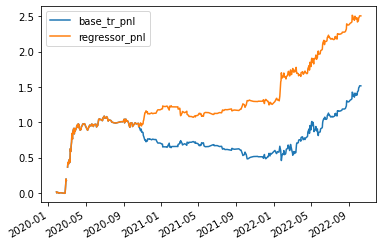

In [14]:
reg_bin_ret[['base_tr_pnl','regressor_pnl']]['2020':].cumsum().plot()

C:\Users\Ian\AppData\Local\Temp\4/ipykernel_18280/2484621253.py:1: FutureWarning: Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.
  reg_bin_ret[['base_tr_pnl','regressor_pnl']]['2022'].cumsum().plot()


<AxesSubplot:>

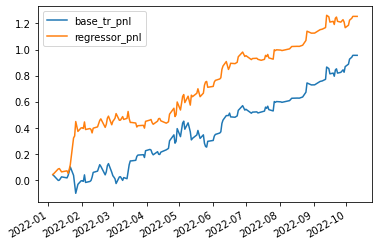

In [12]:
reg_bin_ret[['base_tr_pnl','regressor_pnl']]['2022'].cumsum().plot()

In [184]:
base_binary_pnl = reg_bin_ret[['base_tr_pnl', 'regressor_pnl']].copy()
base_binary_pnl.rename(columns={'base_tr_pnl': 'basetr return', 'regressor_pnl':'binarytr return'}, inplace=True)

base_binary_pnl.to_csv('base_vs_binary_tr_ret.csv')

In [189]:
df_backtest.head()

,base_tr_pnl,opposite_tr_pnl,transaction_type
2013-02-25,0.006668,-0.006793,Bought
2013-02-26,-0.000062,-0.000062,Bought
2013-04-15,0.004627,-0.004747,Bought
2013-04-17,-0.001192,0.001072,Bought
2013-04-19,0.000101,-0.000221,Bought


In [35]:
#non_corr.to_excel('2022_nominal_returns_base_tr_binary.xlsx')

In [15]:
def gen_stats(data, returns, freq=None, window=None, strategy=False):
    
    idx = pd.date_range(data.index[0], data.index[-1], freq="d")
    nyse = mcal.get_calendar('NYSE')
    holidays_nyse = nyse.holidays().holidays

    
    data = data.copy()
    data.drop_duplicates(inplace=True)

    data = data.reindex(idx)
   
    data = data[data.index.dayofweek < 5]
  
    data = data [~data.index.isin(holidays_nyse)]
 
    
    data.fillna(0, inplace=True)
    fract_trade = (data[data['base_tr_pnl'] != 0.000000].shape[0])/data.shape[0]

    target_ret = data[returns]
    

    pfstats = pd.DataFrame(columns=['Strategy'])
                       
    # Mean / std. dev. of return
    ret_m = target_ret.mean()

    ret_s = target_ret.std()

    if freq == 'daily':

        ret_ann = ret_m*252
        ret_vol = ret_s*np.sqrt(252)

    if freq == 'weekly':
        ret_ann = (1+ret_m)*52-1
        ret_vol = ret_s*np.sqrt(52)
        
    pfstats.loc['Ann. Return'] = str(round(ret_ann * 100, 1)) + '%'
    pfstats.loc['Ann. Volatility'] = str(round(ret_vol * 100, 1)) + '%'
    
    # Sharpe
    sharpe = ret_ann/ret_vol
    
    pfstats.loc['Sharpe Ratio (ann.)'] = sharpe.round(2)

    # Maximum Drawdown rolling
    cum_ret = 1000*(1+target_ret).cumprod()-1
    max_dd = cum_ret/cum_ret.rolling(window).max()-1
    max_dd = max_dd.min()
    
    if freq == 'weekly':
        max_dd_string = str(window)+'-W'
    else:
        max_dd_string = str(window)+'-D'

    pfstats.loc['Max. DD ('+max_dd_string+' rolling)'] = str(round(max_dd, 1))
        
 
    # Skewness
    ret_skew = target_ret.skew()
    
    if freq == 'daily':
        ret_skew_ann = ret_skew/np.sqrt(252)
    
    pfstats.loc['Skew (ann.)'] = ret_skew_ann.round(2)
    
    # Fraction of days traded
    pfstats.loc['Days Traded'] = str(int(round(fract_trade * 100, 2))) + '%'
        
    return pfstats

In [17]:
bin_red_pnl = gen_stats(reg_bin_ret, 'regressor_pnl', freq='daily', window=272)
bin_tr = gen_stats(reg_bin_ret, 'base_tr_pnl', freq='daily', window=272)
display(bin_red_pnl)
display(bin_tr)

,Strategy
Ann. Return,26.2%
Ann. Volatility,22.4%
Sharpe Ratio (ann.),1.17
Max. DD (272-D rolling),-0.2
Skew (ann.),0.3
Days Traded,15%


,Strategy
Ann. Return,17.4%
Ann. Volatility,21.1%
Sharpe Ratio (ann.),0.82
Max. DD (272-D rolling),-0.4
Skew (ann.),0.24
Days Traded,15%


### Research

(561, 142)

C:\Users\Ian\AppData\Local\Temp\4/ipykernel_8404/2051907189.py:11: FutureWarning: Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.
  coef_analysis = coef_analysis['2022']


(143, 142)

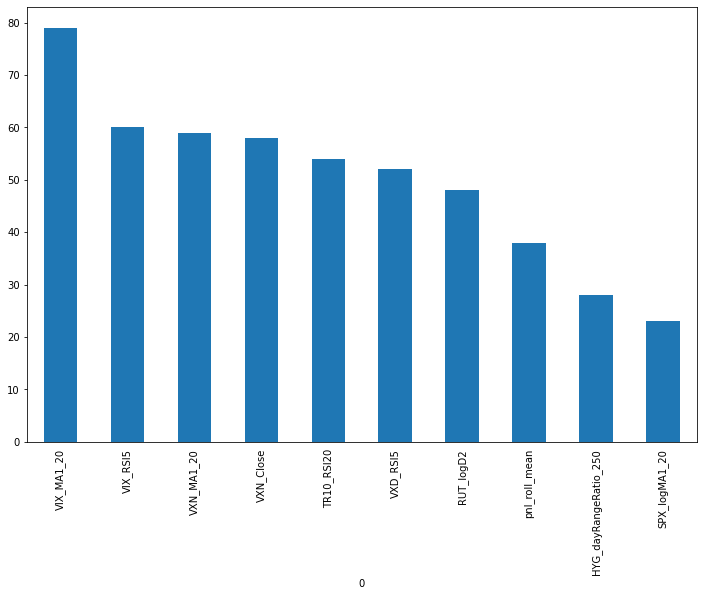

In [174]:
coef_analysis = pd.DataFrame(reg_bin_weights)
display(coef_analysis.shape)
coef_analysis.columns = coef_analysis.iloc[0,:]


coef_analysis = coef_analysis.iloc[1:,:]


coef_analysis.index = reg_bin_ret.index
coef_analysis.index = pd.to_datetime(coef_analysis.index)
coef_analysis = coef_analysis['2022']

display(coef_analysis.shape)
coef_analysis.astype(bool).sum(axis=0).sort_values(ascending=False)[:10].plot(kind='bar', figsize=(12,8))
#plt.axis('off')
plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=True) 

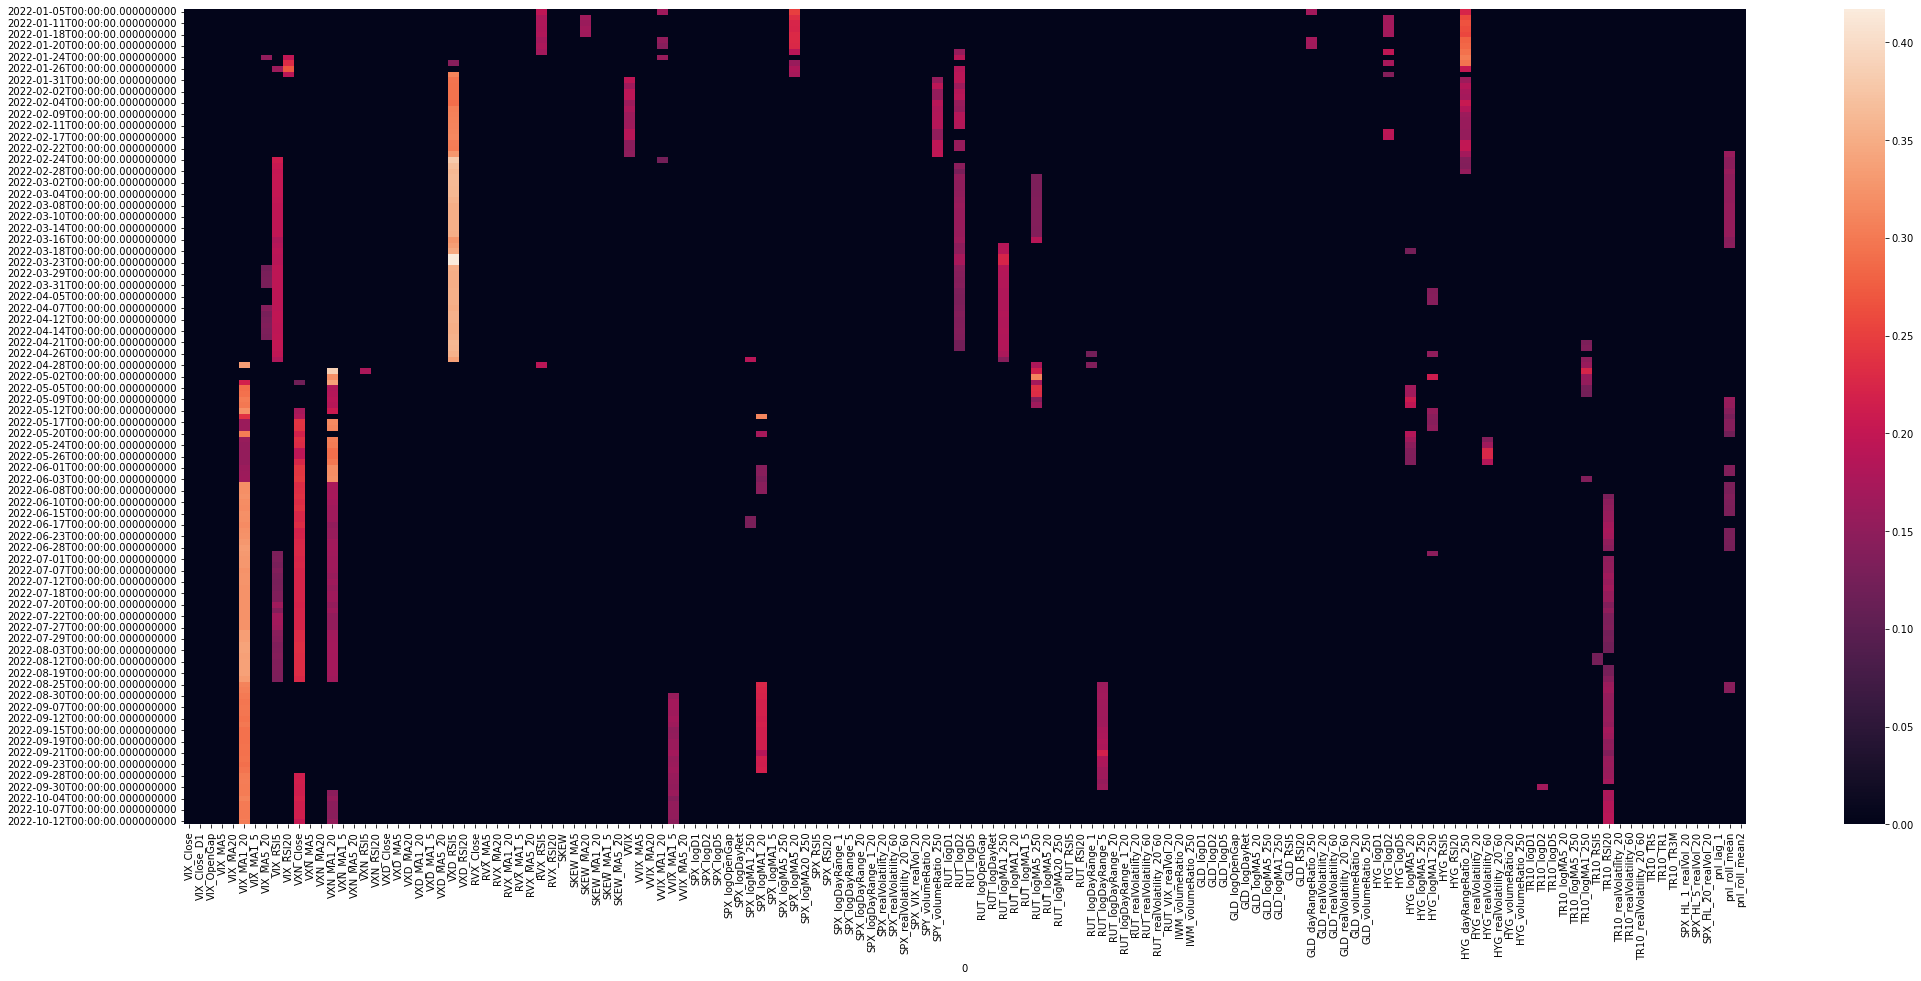

In [175]:
import seaborn as sns

coef_heat = coef_analysis['2021':'2022'].copy()

for i in coef_heat:
    coef_heat[i] = coef_heat[i].astype(float)

plt.figure(figsize=(35, 15))
pt = sns.heatmap(coef_heat, annot=False)

In [10]:
#corr, corr_stats = backtest_output(reg_bin)

In [251]:
reg_bin1.head()

,base_tr_pnl,regressor_pnl
2017-08-10,0.001809,0.001809
2017-08-17,0.002432,0.002432
2018-02-02,0.008572,0.008572
2018-02-05,0.027945,0.027945
2018-02-06,0.006125,0.006125


In [ ]:
reg_bin

In [236]:
display(corr_stats, non_corr_stats)

,Strategy
Ann. Return,28.7%
Ann. Volatility,10.9%
Sharpe Ratio (ann.),2.63
Max. DD (272-D rolling),-0.0
Skew (ann.),0.14


,Strategy
Ann. Return,24.8%
Ann. Volatility,10.8%
Sharpe Ratio (ann.),2.31
Max. DD (272-D rolling),-0.0
Skew (ann.),0.14


In [230]:
# corr.rename(columns={'regressor_pnl':'cor3m_pnl'}, inplace=True)
# corr = corr[['cor3m_pnl']]

non_corr.rename(columns={'regressor_pnl': 'non_cor3m_pnl'}, inplace=True)

whole = corr.merge(non_corr, left_index=True, right_index=True)
display(whole.head())

,cor3m_pnl,base_tr_pnl,non_cor3m_pnl
2018-02-09,-0.010167,-0.010167,-0.010167
2018-02-12,-0.000223,-0.000223,-0.000223
2018-02-14,0.000336,0.000336,0.000336
2018-02-15,0.002259,0.002259,0.002259
2018-02-20,-0.000863,-0.000863,-0.000863


<AxesSubplot:>

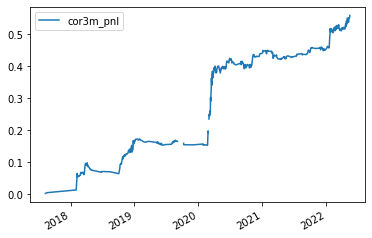

In [231]:
corr.cumsum().plot()

<AxesSubplot:>

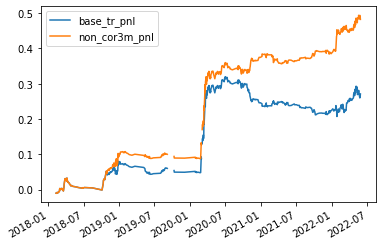

In [222]:
non_corr.cumsum().plot()

<AxesSubplot:>

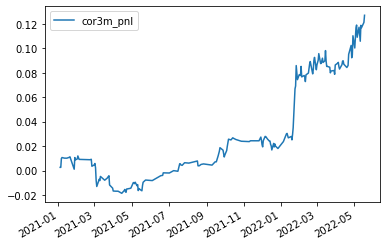

In [149]:
corr['2021':].cumsum().plot()

<AxesSubplot:>

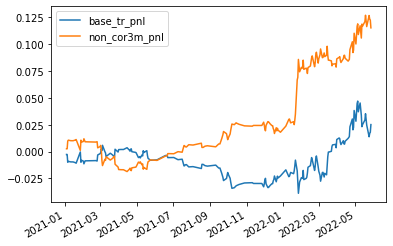

In [150]:
non_corr['2021':].cumsum().plot()

<AxesSubplot:>

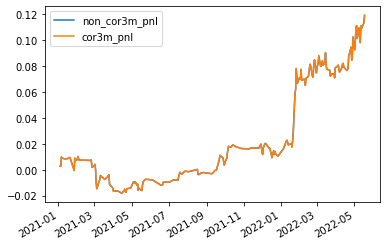

In [241]:
whole[['non_cor3m_pnl', 'cor3m_pnl']]['2021':].cumsum().plot()

In [122]:
bin_red_pnl

,Strategy
Ann. Return,25.2%
Ann. Volatility,10.7%
Sharpe Ratio (ann.),2.35
Max. DD (272-D rolling),-0.0
Skew (ann.),0.13


In [123]:
bin_tr

,Strategy
Ann. Return,16.9%
Ann. Volatility,10.4%
Sharpe Ratio (ann.),1.62
Max. DD (272-D rolling),-0.1
Skew (ann.),0.13


In [160]:
reg_bin.head()

,average,return_to_exit True Value
2017-08-10,80.470001,220.36
2017-08-17,79.400002,295.36
2018-02-02,80.559998,1182.86
2018-02-05,181.949997,3695.36
2018-02-06,597.090027,820.36


In [161]:
coef_analysis_d.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147
0,VIX_Close,VIX_Close_D1,VIX_OpenGap,VIX_MA5,VIX_MA20,VIX_MA1_20,VIX_MA1_5,VIX_MA5_20,VIX_RSI5,VIX_RSI20,VXN_Close,VXN_MA5,VXN_MA20,VXN_MA1_20,VXN_MA1_5,VXN_MA5_20,VXN_RSI5,VXN_RSI20,VXD_Close,VXD_MA5,VXD_MA20,VXD_MA1_20,VXD_MA1_5,VXD_MA5_20,VXD_RSI5,VXD_RSI20,RVX_Close,RVX_MA5,RVX_MA20,RVX_MA1_20,RVX_MA1_5,RVX_MA5_20,RVX_RSI5,RVX_RSI20,SKEW,SKEW_MA5,SKEW_MA20,SKEW_MA1_20,SKEW_MA1_5,SKEW_MA5_20,COR3M_Close,COR3M_MA5,COR3M_MA20,COR3M_MA1_20,COR3M_MA1_5,COR3M_MA5_20,VVIX,VVIX_MA5,VVIX_MA20,VVIX_MA1_20,VVIX_MA1_5,VVIX_MA5_20,SPX_logD1,SPX_logD2,SPX_logD5,SPX_logOpenGap,SPX_logDayRet,SPX_logMA1_250,SPX_logMA1_20,SPX_logMA1_5,SPX_logMA5_250,SPX_logMA5_20,SPX_logMA20_250,SPX_RSI5,SPX_RSI20,SPX_logDayRange_1,SPX_logDayRange_5,SPX_logDayRange_20,SPX_logDayRange_1_20,SPX_realVolatility_20,SPX_realVolatility_60,SPX_realVolatility_20_60,SPX_VIX_realVol_20,SPY_volumeRatio_20,SPY_volumeRatio_250,RUT_logD1,RUT_logD2,RUT_logD5,RUT_logOpenGap,RUT_logDayRet,RUT_logMA1_250,RUT_logMA1_20,RUT_logMA1_5,RUT_logMA5_250,RUT_logMA5_20,RUT_logMA20_250,RUT_RSI5,RUT_RSI20,RUT_logDayRange_1,RUT_logDayRange_5,RUT_logDayRange_20,RUT_logDayRange_1_20,RUT_realVolatility_20,RUT_realVolatility_60,RUT_realVolatility_20_60,RUT_VIX_realVol_20,IWM_volumeRatio_20,IWM_volumeRatio_250,GLD_logD1,GLD_logD2,GLD_logD5,GLD_logOpenGap,GLD_logDayRet,GLD_logMA5_20,GLD_logMA5_250,GLD_logMA1_250,GLD_RSI5,GLD_RSI20,GLD_dayRangeRatio_250,GLD_realVolatility_20,GLD_realVolatility_60,GLD_realVolatility_20_60,GLD_volumeRatio_20,GLD_volumeRatio_250,HYG_logD1,HYG_logD2,HYG_logD5,HYG_logMA5_20,HYG_logMA5_250,HYG_logMA1_250,HYG_RSI5,HYG_RSI20,HYG_dayRangeRatio_250,HYG_realVolatility_20,HYG_realVolatility_60,HYG_realVolatility_20_60,HYG_volumeRatio_20,HYG_volumeRatio_250,TR10_logD1,TR10_logD2,TR10_logD5,TR10_logMA5_20,TR10_logMA5_250,TR10_logMA1_250,TR10_RSI5,TR10_RSI20,TR10_realVolatility_20,TR10_realVolatility_60,TR10_realVolatility_20_60,TR10_TR5,TR10_TR1,TR10_TR3M,SPX_HL_1_realVol_20,SPX_HL_5_realVol_20,SPX_HL_20_realVol_20,pnl_lag_1,pnl_roll_mean,pnl_roll_mean2
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.372784,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.331654,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.295562,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.373086,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.332327,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.294588,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.372756,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.331593,0.0,0.0

(493, 148)

C:\Users\Ian\AppData\Local\Temp\4/ipykernel_32656/2551725637.py:10: FutureWarning: Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.
  coef_analysis_d = coef_analysis_d['2022-5']


(10, 148)

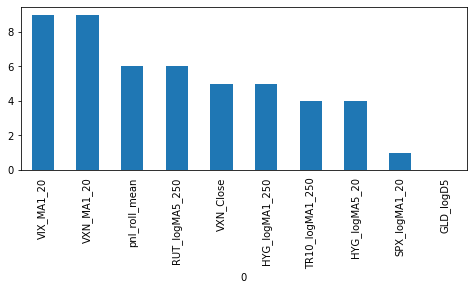

In [245]:
coef_analysis_d = pd.DataFrame(coef_weights)
display(coef_analysis_d.shape)
coef_analysis_d.columns = coef_analysis_d.iloc[0,:]
#coef_analysis_d = coef_analysis_d.loc[:,'COR3M_Close': 'COR3M_MA5_20']

coef_analysis_d = coef_analysis_d.iloc[1:,:]

coef_analysis_d.index = reg_bin.index
coef_analysis_d.index = pd.to_datetime(coef_analysis_d.index)
coef_analysis_d = coef_analysis_d['2022-5']

display(coef_analysis_d.shape)
coef_analysis_d.astype(bool).sum(axis=0).sort_values(ascending=False)[:10].plot(kind='bar', figsize=(8,3))
#plt.axis('off')
plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=True)

In [246]:
coef_analysis_d.head(0)

,VIX_Close,VIX_Close_D1,VIX_OpenGap,VIX_MA5,VIX_MA20,VIX_MA1_20,VIX_MA1_5,VIX_MA5_20,VIX_RSI5,VIX_RSI20,VXN_Close,VXN_MA5,VXN_MA20,VXN_MA1_20,VXN_MA1_5,VXN_MA5_20,VXN_RSI5,VXN_RSI20,VXD_Close,VXD_MA5,VXD_MA20,VXD_MA1_20,VXD_MA1_5,VXD_MA5_20,VXD_RSI5,VXD_RSI20,RVX_Close,RVX_MA5,RVX_MA20,RVX_MA1_20,RVX_MA1_5,RVX_MA5_20,RVX_RSI5,RVX_RSI20,SKEW,SKEW_MA5,SKEW_MA20,SKEW_MA1_20,SKEW_MA1_5,SKEW_MA5_20,COR3M_Close,COR3M_MA5,COR3M_MA20,COR3M_MA1_20,COR3M_MA1_5,COR3M_MA5_20,VVIX,VVIX_MA5,VVIX_MA20,VVIX_MA1_20,VVIX_MA1_5,VVIX_MA5_20,SPX_logD1,SPX_logD2,SPX_logD5,SPX_logOpenGap,SPX_logDayRet,SPX_logMA1_250,SPX_logMA1_20,SPX_logMA1_5,SPX_logMA5_250,SPX_logMA5_20,SPX_logMA20_250,SPX_RSI5,SPX_RSI20,SPX_logDayRange_1,SPX_logDayRange_5,SPX_logDayRange_20,SPX_logDayRange_1_20,SPX_realVolatility_20,SPX_realVolatility_60,SPX_realVolatility_20_60,SPX_VIX_realVol_20,SPY_volumeRatio_20,SPY_volumeRatio_250,RUT_logD1,RUT_logD2,RUT_logD5,RUT_logOpenGap,RUT_logDayRet,RUT_logMA1_250,RUT_logMA1_20,RUT_logMA1_5,RUT_logMA5_250,RUT_logMA5_20,RUT_logMA20_250,RUT_RSI5,RUT_RSI20,RUT_logDayRange_1,RUT_logDayRange_5,RUT_logDayRange_20,RUT_logDayRange_1_20,RUT_realVolatility_20,RUT_realVolatility_60,RUT_realVolatility_20_60,RUT_VIX_realVol_20,IWM_volumeRatio_20,IWM_volumeRatio_250,GLD_logD1,GLD_logD2,GLD_logD5,GLD_logOpenGap,GLD_logDayRet,GLD_logMA5_20,GLD_logMA5_250,GLD_logMA1_250,GLD_RSI5,GLD_RSI20,GLD_dayRangeRatio_250,GLD_realVolatility_20,GLD_realVolatility_60,GLD_realVolatility_20_60,GLD_volumeRatio_20,GLD_volumeRatio_250,HYG_logD1,HYG_logD2,HYG_logD5,HYG_logMA5_20,HYG_logMA5_250,HYG_logMA1_250,HYG_RSI5,HYG_RSI20,HYG_dayRangeRatio_250,HYG_realVolatility_20,HYG_realVolatility_60,HYG_realVolatility_20_60,HYG_volumeRatio_20,HYG_volumeRatio_250,TR10_logD1,TR10_logD2,TR10_logD5,TR10_logMA5_20,TR10_logMA5_250,TR10_logMA1_250,TR10_RSI5,TR10_RSI20,TR10_realVolatility_20,TR10_realVolatility_60,TR10_realVolatility_20_60,TR10_TR5,TR10_TR1,TR10_TR3M,SPX_HL_1_realVol_20,SPX_HL_5_realVol_20,SPX_HL_20_realVol_20,pnl_lag_1,pnl_roll_mean,pnl_roll_mean2


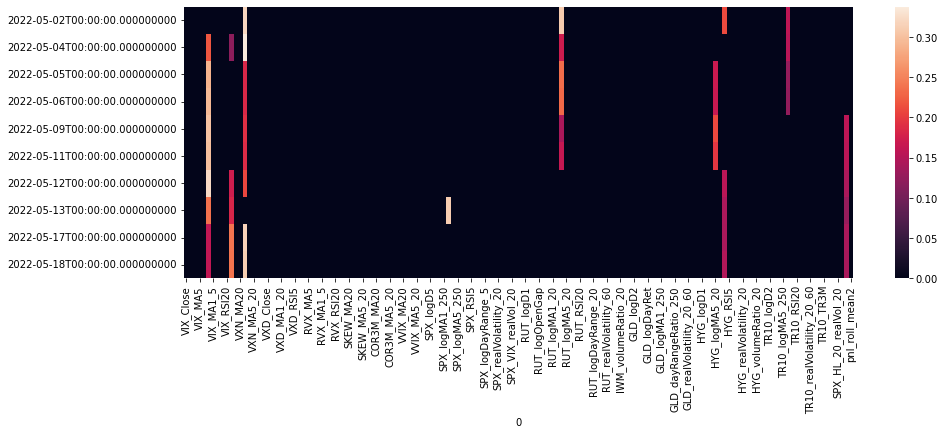

In [247]:
import seaborn as sns

coef_heat = coef_analysis_d.copy()

for i in coef_heat:
    coef_heat[i] = coef_heat[i].astype(float)

plt.figure(figsize=(15, 5))
pt = sns.heatmap(coef_heat, annot=False)